In [1]:
# Official packages
import os
import copy
import math

# Third-party packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# In-house packages
from BrukerSpSpEpi import BrukerSpSpEpiExp


In [2]:


def zerofill_fid_2d(fid_2d):
    nbr_zerofill_lines = spsp_epi._exp_data_dim_dict['dim_r_image_ph'] - spsp_epi._exp_data_dim_dict['dim_k_raw_ph']
    zerofilled_fid_2d = np.pad(fid_2d, ((nbr_zerofill_lines, 0),(0, 0)), 'constant', constant_values=(0))
    return zerofilled_fid_2d

def split_fid_2d(fid_2d):
    fid_left = fid_2d[...,:spsp_epi._exp_data_dim_dict['dim_k_raw_ro']:]
    fid_right = fid_2d[...,spsp_epi._exp_data_dim_dict['dim_k_raw_ro']::]
    return fid_left, fid_right

def mirror_odd_lines(fid_2d):
    mirrored_fid_2d = copy.deepcopy(fid_2d)
    for line_nbr, line in enumerate(mirrored_fid_2d):
        if (line_nbr % 2 ):
             mirrored_fid_2d[line_nbr] = line[::-1,...]
    return mirrored_fid_2d

def synthesize_phase_conjugate_fid_2d(fid_2d):
    synthesized_fid_2d = copy.deepcopy(fid_2d)
    for line_idx, line in enumerate(fid_2d):
        if (not line.any()):
            line = zerofilled_fid_2d[-1*line_idx]
            synthesized_fid_2d[line_idx] = line[::-1]
    return synthesized_fid_2d

def align_echo_center(fid_2d):
    aligned_fid_2d = copy.deepcopy(fid_2d)
    for idx, line in enumerate(fid_2d):
        shift = 60 - np.argmax(np.abs(line))
        aligned_fid_2d[idx] = np.roll(line, shift)
    return aligned_fid_2d

def _normalize(array):
    return array/np.max(array)

def view_epi_slice_3d(spsp_epi_exp):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    #X, Y, Z = axes3d.get_test_data(0.01)

    _x = np.arange(0, spsp_epi_exp._exp_data_dim_dict['dim_r_image_ro'], 1 )
    _y = np.arange(0, spsp_epi_exp._exp_data_dim_dict['dim_r_image_ph'], 1)

    X, Y = np.meshgrid(_x, _y)
    Z = _normalize(spsp_epi_exp.r_space_data['Mag'])

    # Plot the 3D surface
    ax.plot_surface(X, Y, Z, cmap=cm.RdGy_r, linewidth=0.5, antialiased=False,alpha=0.25)

    # Plot projections of the contours for each dimension.  By choosing offsets
    # that match the appropriate axes limits, the projected contours will sit on
    # the 'walls' of the graph
    cset = ax.contour(X, Y, Z, zdir='z', offset=-.1, cmap=cm.seismic, alpha=0.99)

    x = np.arange(0, spsp_epi_exp._exp_data_dim_dict['dim_r_image_ro'], 1 )
    y = _normalize(spsp_epi_exp.magnitude_proj['ph'])
    ax.plot(x, y, zs=0, zdir='x', label='curve in (x, y)')

    x = np.arange(0, spsp_epi_exp._exp_data_dim_dict['dim_r_image_ph'], 1 )
    y = _normalize(spsp_epi_exp.magnitude_proj['ro'])
    ax.plot(x, y, zs=120, zdir='y', label='curve in (x, y)')

    ax.set_xlim(-0, 120)
    ax.set_ylim(-0, 120)
    ax.set_zlim(-.1, 1)

    ax.set_xlabel('Ph-Direction')
    ax.set_ylabel('RO-Direction')
    ax.set_zlabel('Normalized Intensity [1]')

    plt.show()



def process_fid(raw_fid):
    test_fid = np.array(np.array_split(raw_fid,16))
    k_space = {}
 
    k_space['Pos'] = np.squeeze(test_fid[...,:16:])
    k_space['Neg'] = np.squeeze(test_fid[...,16::])
    
    r_space["Pos"] = np.fft.fftshift(np.fft.fft2(k_space["Pos"]))
    r_space["Neg"] = np.fft.fftshift(np.fft.fft2(k_space["Neg"]))
    r_space["Abs"]  = np.abs(r_space['Pos']) + np.abs(r_space['Neg'])

    return k_space, r_space

In [3]:
calib_exp_dir = "C:\\Users\\Xiao JI\\OneDrive - University of California, San Francisco\\Documents\\Projects\\SpectroSpatial\\BrukerSpSpEPI\\20230305_163320_AgroseCylinder2_1_1\\21"
        
spsp_epi_calib = BrukerSpSpEpiExp(calib_exp_dir)





In [4]:
overflow_exp_dir = "../LTL610_014_HP_spspEPI_6.0.1//20"

spsp_epi_overflow = BrukerSpSpEpiExp(overflow_exp_dir)

In [5]:
intervals = np.tile(spsp_epi_overflow.dataset['PARAM']['ACQ_repetition_time']/1000, reps=spsp_epi_overflow.dataset['PARAM']['NR']) + np.tile(spsp_epi_overflow.dataset['PARAM']['Vd1List'], reps=int(spsp_epi_overflow.dataset['PARAM']['NR'] / spsp_epi_overflow.dataset['PARAM']["NumChemicalShifts"]))

intervals = np.concatenate((np.array([0]), intervals[:-1:]))

intervals = np.cumsum(intervals)

print(all(intervals == spsp_epi_overflow.dataset['DATA']['time_point_sec']))


True


In [6]:
a = range(120)

a= np.reshape(a,(4,3,-1))
print(a, "\n"*3)

a= np.swapaxes(a, axis1=0, axis2=1)
print(a)



[[[  0   1   2   3   4   5   6   7   8   9]
  [ 10  11  12  13  14  15  16  17  18  19]
  [ 20  21  22  23  24  25  26  27  28  29]]

 [[ 30  31  32  33  34  35  36  37  38  39]
  [ 40  41  42  43  44  45  46  47  48  49]
  [ 50  51  52  53  54  55  56  57  58  59]]

 [[ 60  61  62  63  64  65  66  67  68  69]
  [ 70  71  72  73  74  75  76  77  78  79]
  [ 80  81  82  83  84  85  86  87  88  89]]

 [[ 90  91  92  93  94  95  96  97  98  99]
  [100 101 102 103 104 105 106 107 108 109]
  [110 111 112 113 114 115 116 117 118 119]]] 



[[[  0   1   2   3   4   5   6   7   8   9]
  [ 30  31  32  33  34  35  36  37  38  39]
  [ 60  61  62  63  64  65  66  67  68  69]
  [ 90  91  92  93  94  95  96  97  98  99]]

 [[ 10  11  12  13  14  15  16  17  18  19]
  [ 40  41  42  43  44  45  46  47  48  49]
  [ 70  71  72  73  74  75  76  77  78  79]
  [100 101 102 103 104 105 106 107 108 109]]

 [[ 20  21  22  23  24  25  26  27  28  29]
  [ 50  51  52  53  54  55  56  57  58  59]
  [ 80  81  82  

In [7]:
np.shape(spsp_epi_overflow.dataset['DATA']['fid'])


(54, 512)

In [8]:
np.shape(spsp_epi_overflow.dataset['DATA']['2dseq'])


(54, 16, 16)

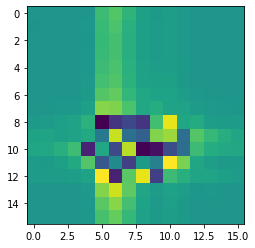

In [9]:
plt.figure()
plt.imshow(spsp_epi_overflow.dataset['DATA']['2dseq'][2])
plt.show()


In [10]:
print(spsp_epi_overflow.dataset['DATA']['k_space'])

None


In [11]:
spsp_epi_calib = BrukerSpSpEpiExp(calib_exp_dir, does_reconstruction=True)


print(spsp_epi_calib.post_processing_params['has_double_sampling'])
print(np.shape(spsp_epi_calib.dataset['DATA']['k_space']['Pos']))

True
(1, 80, 120)


(54, 16, 16)


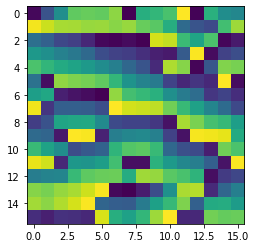

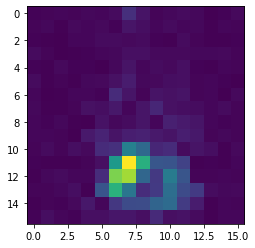

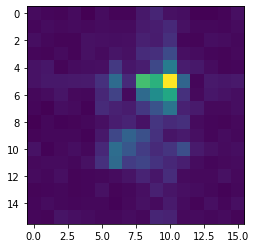

In [16]:
spsp_epi_overflow = BrukerSpSpEpiExp(overflow_exp_dir, does_reconstruction=True, does_zerofill=True)


print(np.shape(spsp_epi_overflow.dataset['DATA']['k_space']['Pos']))

plt.figure()
plt.imshow(np.angle(spsp_epi_overflow.dataset['DATA']['k_space']['Pos'][0]))
plt.show()

plt.figure()
plt.imshow(np.abs(spsp_epi_overflow.dataset['DATA']['r_image']['Pos'][0]))
plt.show()

plt.figure()
plt.imshow((spsp_epi_overflow.dataset['DATA']['r_image']['Abs'][]))
plt.show()